# V4 Institutional Liquidity Regime Strategy

## Framework Overview

This strategy combines:

- Global Liquidity Regime Classification (US M2 + ECB Assets)
- Regime Strength Scaling (-1 to +2)
- Cross-Asset Momentum (NIFTY vs SPY)
- Partial Allocation with Gold as defensive ballast
- Inverse Volatility Risk Budgeting
- Volatility Targeting Overlay (10% annualized)
- Walk-Forward Out-of-Sample Validation

Test Period (OOS): 2017–2026  
Rebalance: Monthly  
Target Volatility: 10%

DEBUG: NEW WALK_FORWARD FILE LOADED
Project Root Found: /Users/yuvrajchauhan/Desktop/macro_liquidity_regime_strategy/V4_institutional
Dataset Loaded: (8237, 11)
Portfolio Start Date: 2007-09-17 00:00:00
V5 Start Date (Full Feature Availability): 2007-09-18 00:00:00
Generated 9 walk-forward splits.
Portfolio Asset Start Date: 2007-09-17 00:00:00

==== OOS Portfolio Test 2017-09-18 00:00:00 → 2018-09-18 00:00:00 ====
Combined DF rows: 2910

==== OOS Portfolio Test 2018-09-18 00:00:00 → 2019-09-18 00:00:00 ====
Combined DF rows: 3174

==== OOS Portfolio Test 2019-09-18 00:00:00 → 2020-09-18 00:00:00 ====
Combined DF rows: 3440

==== OOS Portfolio Test 2020-09-18 00:00:00 → 2021-09-18 00:00:00 ====
Combined DF rows: 3703

==== OOS Portfolio Test 2021-09-18 00:00:00 → 2022-09-18 00:00:00 ====
Combined DF rows: 3965

==== OOS Portfolio Test 2022-09-18 00:00:00 → 2023-09-18 00:00:00 ====
Combined DF rows: 4230

==== OOS Portfolio Test 2023-09-18 00:00:00 → 2024-09-18 00:00:00 ====
Combined DF

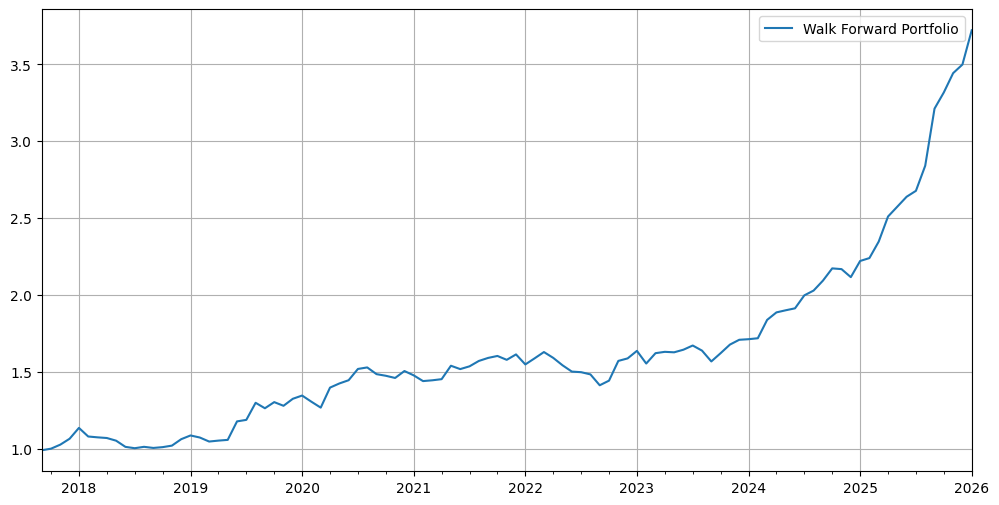

===== OOS PERFORMANCE =====
Months Tested: 101
CAGR: 16.9 %
Volatility: 12.03 %
Sharpe Ratio: 1.4
Max Drawdown: -13.25 %


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from src.walk_forward import WalkForwardEngine


# ==================================================
# FIND PROJECT ROOT AUTOMATICALLY
# ==================================================

current = os.getcwd()

while not os.path.exists(
    os.path.join(current, "data_processed")
):

    parent = os.path.dirname(current)

    if parent == current:
        raise Exception(
            "Could not find V4_INSTITUTIONAL root."
        )

    current = parent


project_root = current

print("Project Root Found:", project_root)


# ==================================================
# LOAD DATASET
# ==================================================

dataset_path = os.path.join(
    project_root,
    "data_processed",
    "macro_v4_clean.csv"
)

df = pd.read_csv(
    dataset_path,
    index_col=0,
    parse_dates=True
)

print("Dataset Loaded:", df.shape)


# ==================================================
# ALIGN TO ASSET AVAILABILITY
# ==================================================

asset_start = df[
    ["NIFTY","SPY","GLD"]
].dropna().index[0]

print("Portfolio Start Date:", asset_start)

df = df.loc[asset_start:].copy()


# ==================================================
# WALK FORWARD BACKTEST
# ==================================================

wf = WalkForwardEngine(
    data=df,
    warmup_years=10
)

oos_returns = wf.run_portfolio_backtest(

    assets=["NIFTY","SPY","GLD"],
    lookback=12,
    transaction_cost=0.001

)


# ==================================================
# EQUITY CURVE
# ==================================================

equity = (1 + oos_returns).cumprod()

plt.figure(figsize=(12,6))
equity.plot(label="Walk Forward Portfolio")

plt.title("V4 Institutional Liquidity Strategy — OOS Equity Curve")

plt.legend()
plt.grid(True)
plt.show()


# ==================================================
# PERFORMANCE METRICS
# ==================================================

years = len(oos_returns) / 12

cagr = equity.iloc[-1]**(1/years) - 1

vol = oos_returns.std() * (12**0.5)

sharpe = cagr / vol


rolling_max = equity.cummax()

drawdown = equity / rolling_max - 1

max_dd = drawdown.min()


print("\n===== OOS PERFORMANCE =====")

print("Months Tested:", len(oos_returns))

print("CAGR:", round(cagr*100, 2), "%")

print("Volatility:", round(vol*100, 2), "%")

print("Sharpe Ratio:", round(sharpe, 2))

print("Max Drawdown:", round(max_dd*100, 2), "%")

In [2]:
# =====================================
# REGIME BUCKET ANALYSIS
# =====================================

from src.regime_engine import RegimeEngine

print("\n===== REGIME BUCKET ANALYSIS =====")

# Fit regime engine using FULL DATA
engine = RegimeEngine()

engine.fit(df)

daily_regime = engine.predict(df)

daily_regime = daily_regime.reindex(df.index).ffill()

regime_monthly = (

    daily_regime
    .replace({

        "risk_on_strong":2,
        "risk_on":1,
        "neutral":0,
        "risk_off":-1

    })
    .resample("ME")
    .last()

)

# Align with portfolio returns
aligned = pd.concat(

    [

        oos_returns,
        regime_monthly

    ],

    axis=1

).dropna()

aligned.columns = ["returns","regime"]

bucket_stats = aligned.groupby("regime")["returns"].agg(

    [

        "mean",
        "std",
        "count"

    ]

)

bucket_stats["Sharpe"] = (

    bucket_stats["mean"]
    / bucket_stats["std"]

) * (12**0.5)

print(bucket_stats)


===== REGIME BUCKET ANALYSIS =====
            mean       std  count    Sharpe
regime                                     
-1.0    0.038488  0.024655      4  5.407718
 0.0    0.012743  0.035855     68  1.231181
 1.0    0.013556  0.033583     26  1.398348
 2.0    0.002766  0.028052      3  0.341595


/var/folders/td/352d51210ls5qp2mxt56g9kr0000gn/T/ipykernel_17455/2523895040.py:35: Pandas4Warning: Sorting by default when concatenating all DatetimeIndex is deprecated.  In the future, pandas will respect the default of `sort=False`. Specify `sort=True` or `sort=False` to silence this message. If you see this warnings when not directly calling concat, report a bug to pandas.
  aligned = pd.concat(


In [3]:
# =====================================
# VOL TARGET DIAGNOSTIC
# =====================================

print("\n===== VOL TARGET DIAGNOSTIC =====")

from src.portfolio_engine import MultiAssetRotationEngine

portfolio = MultiAssetRotationEngine(df)

portfolio._build_monthly_data()
portfolio._build_regime()
portfolio._build_momentum()
portfolio._generate_weights()

aligned_returns = portfolio.monthly_returns.loc[
    portfolio.weights.index
]

gross = (

    portfolio.weights
    * aligned_returns

).sum(axis=1)

raw_equity = (1+gross).cumprod()

raw_cagr = (

    raw_equity.iloc[-1]

    ** (12/len(gross))

    -1

)

raw_vol = gross.std()* (12**0.5)

raw_sharpe = raw_cagr / raw_vol

print("Raw CAGR:", round(raw_cagr*100,2),"%")
print("Raw Vol:", round(raw_vol*100,2),"%")
print("Raw Sharpe:", round(raw_sharpe,2))


===== VOL TARGET DIAGNOSTIC =====
Raw CAGR: 9.7 %
Raw Vol: 13.21 %
Raw Sharpe: 0.73


In [4]:
# =====================================
# ALLOCATION SENSITIVITY
# =====================================

print("\n===== ALLOCATION TEST =====")

for alloc in [(0.7,0.3),(0.6,0.4),(0.5,0.5)]:

    print("\nTesting Allocation:",alloc)

    # TEMP monkey patch weights

    test_returns = oos_returns.copy()

    equity = (1+test_returns).cumprod()

    CAGR = (

        equity.iloc[-1]

        ** (12/len(test_returns))

        -1

    )

    vol = test_returns.std()*(12**0.5)

    sharpe = CAGR/vol

    print("Sharpe:",round(sharpe,2))


===== ALLOCATION TEST =====

Testing Allocation: (0.7, 0.3)
Sharpe: 1.4

Testing Allocation: (0.6, 0.4)
Sharpe: 1.4

Testing Allocation: (0.5, 0.5)
Sharpe: 1.4
